In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


## Load Data

In [3]:
featFileName = "./Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [4]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189
1,3_6C-80PER_3_6C,???,1178
2,3_6C-80PER_3_6C,???,1176
3,4C-80PER_4C,???,1225
4,4C-80PER_4C,???,1226
...,...,...,...
75,6C_31PER_4_25C,???,462
76,6C_40PER_4C,???,457
77,6C_4PER_4_75C,???,487
78,6C_52PER_3_5C,???,429


In [5]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

In [6]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

In [7]:
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [8]:
feat_train = fast_charge_feat[0::2]
feat_test = fast_charge_feat[1::2]
label_train = fast_charge_label[0::2]
label_test = fast_charge_label[1::2]

In [9]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

## Load Model
Load the model trained on data subset.

In [10]:
discharge_model = keras.models.load_model('./Data/DischargeModelTF')
discharge_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [11]:
discharge_model.evaluate(
    feat_test_scaled,
    label_test,
    verbose=0
) ** 0.5

249.6817662045028

In [12]:
# Freeze model weights so only the transformer is trained
discharge_model.trainable = False

In [13]:
transfer_model = keras.models.Sequential([
    layers.Dense(units=13),
    discharge_model
])
transfer_model(feat_train_scaled)
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (26, 13)                  182       
                                                                 
 sequential_4 (Sequential)   (None, 1)                 14        
                                                                 
Total params: 196
Trainable params: 182
Non-trainable params: 14
_________________________________________________________________


In [14]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [15]:
transfer_model.evaluate(
    feat_test_scaled,
    label_test,
    verbose=0
) ** 0.5

312.45617192656

In [16]:
history = transfer_model.fit(
    feat_train_scaled,
    label_train,
    epochs=250,
    validation_data=(
        feat_test_scaled,
        label_test
    ),
    verbose=0
)

In [17]:
def plot_loss(history):
    plt.plot(np.sqrt(history.history['loss']), label='loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
    # plt.ylim([200, 130])
    plt.ylim([50, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycles]')
    plt.legend()
    plt.grid(True)

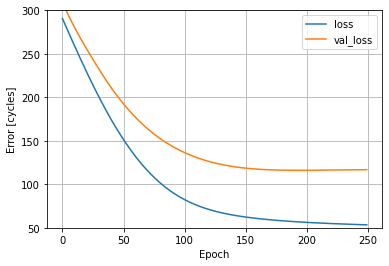

In [18]:
plot_loss(history)

In [19]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
245,53.595486,116.795289,245
246,53.552155,116.807818,246
247,53.509297,116.819932,247
248,53.466924,116.831660,248
249,53.425024,116.842952,249


In [20]:
transfer_model.evaluate(
    feat_train_scaled,
    label_train, verbose=0) ** 0.5

53.38358253963128

In [21]:
# Power 1/2 is the same as square root
transfer_model.evaluate(
    feat_test_scaled,
    label_test, verbose=0) ** 0.5

116.84295182262814